энкодер- декодер. Отличие от предыдущей версии - вместо растра точек на вход сети подать вектора лендмарков в виде набора координат и длин.

In [13]:
# from keras.datasets import mnist
import numpy as np
# from jaw_gen import *
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
import cv2

from tqdm import tqdm

In [14]:
# класс который генерит картинки размерностью с искривлениями зубов или без.
# основное отличие - генерятся не картинки с зубами, а данные в виде 
# [[метка][координаты точки начала, длина вектора]]
# 

# print(f" cv2 ver. {cv2.__version__}, np ver. {np.__version__}")
np.random.seed() # устанавливает режим случайных чисел без повторений от запуска к запуску

class Landmark_gen():
    ''' creates pictures with incistor edges landmarks '''

    def __init__(self, number=100, dim=(200, 200)):
        # self.number = number # нафиг нигде не сперлось? Удалять?
        self.dim = dim

    def image_gen(  self, 
                    name='_', 
                    scale1=1, 
                    factor=2.6, 
                    shift_x=0, 
                    shift_y=0, 
                    spoiled = False,    # вводит хаотичный наклон и смещение зубов имитируя T1
                    shiftX = False,     # add random shift for whole tooth for X axis
                    shiftY = False,     # add random shift for whole tooth for Y axis
                    show=False):
        # 
        # все делаем под разрешение 200x200 
        self.back = np.zeros(self.dim)            # картинка с ровными зубами
        self.back_spoiled = np.zeros(self.dim)     # картинка с корявыми зубами
        self.factor = factor
        self.out_vector = []                        # вектор лендмарков [x,y,len_x, len_y]
        self.out_vector_spoiled = []                # то же, но искривленные зубы
        center = (self.dim[0]//2, self.dim[1]//2)
        # оси координат по центру
        if 1:
            cv2.line(self.back, (0, center[1]), (self.dim[0], center[1]), 0.4, 1)
            cv2.line(self.back, (center[0], 0), (center[0], self.dim[1]), 0.4, 1)
            cv2.line(self.back_spoiled, (0, center[1]), (self.dim[0], center[1]), 0.4, 1)
            cv2.line(self.back_spoiled, (center[0], 0), (center[0], self.dim[1]), 0.4, 1)

        # строим дугу. так чтобы на основе ее точек можно было зубья подровнять
        for i in range(-8, 8):
            # строим точки графика
            # первая точка зуба
            point_ = [int(i*scale1)+center[0], int(self.duga(i)) + center[1]]
            # вторая
            point2_ = [int((i+1-0.2)*scale1 +
                          center[0]), int(self.duga(i+1-0.2)) + center[1]]
            
            # строим линии по дуге - ровные зубы
            cv2.line(self.back, point_, point2_, 1, 2)
            # добавляем координаты точек в выдачу
            len_x = point2_[0] - point_[0]
            len_y = point2_[1] - point_[1]
            self.out_vector.append([point_[0], point_[1], len_x, len_y])

            # шатаем зубы если задано шатать и выдаем на картинку back_spoiled
            if spoiled: 
                if i in [-8, -7, -6, 5, 6, 7 ]: # портим моляры 
                    point_[0]+= int((np.random.sample()-1)*i)

                if i in [-5, -4, -3, -2, 1, 2, 3, 4]: # премоляры и резцы
                    point_[1]+= int((np.random.sample()-1)*i*2)

                if i in [-1, 0]: # передние резцы
                    point_[1]+= int((np.random.sample()-1)*4)
            
            if shiftX:
                case_shift_x_ = int((np.random.sample()-1)*5)
                point_[0] += case_shift_x_
                point2_[0] += case_shift_x_
            
            if shiftY:
                case_shift_y_ = int((np.random.sample()-1)*5)
                point_[1] += case_shift_y_
                point2_[1] += case_shift_y_
            
            # для второй картинки сторим покореженные зубы. или те-же если корежить не надо
            cv2.line(self.back_spoiled, point_, point2_, 1, 2)
            len_x = point2_[0] - point_[0]
            len_y = point2_[1] - point_[1]
            # добавляем координаты точек в выдачу
            self.out_vector_spoiled.append([point_[0], point_[1], len_x, len_y])
            
            # cv2.circle(self.back, point_, 1, 0.2, 1)
        # print (f"self.back shape {self.back.shape}")

        if show: # shows picture. beware using in batсh processing
            self.back = cv2.resize(self.back, self.dim)  # увеличиваем только для показа
            self.back_spoiled = cv2.resize(self.back_spoiled, self.dim)  # увеличиваем только для показа
            img_for_show = np.hstack((self.back, self.back_spoiled))
            cv2.imshow(name, img_for_show)
            k = cv2.waitKey()

        return self.back, self.back_spoiled, self.out_vector, self.out_vector_spoiled  

    def duga(self, x):
        ''' returns arc function'''
        return abs(x)**self.factor - self.dim[0] * 0.35

    # @staticmethod
    def draw_pic_fr_vec(self, vec):
        # get landmarks and Draw pictures
        # vec это вектор лендмарка длиной 16, vec[i] = [x,y, x_len, y_len]
        self.pred_pict = np.zeros(self.dim)   
        for i in range(len(vec)):
            x,y, x_len, y_len = vec[i]
            cv2.line(self.pred_pict, (int(x), int(y)), 
                (int(x+x_len), int(y+y_len)), 1, 2)
        
        return self.pred_pict
     

In [15]:
# проверка функции нарисования предиктной картинки - ok
scale =  9
factor = 2.2
inst_t = Landmark_gen()
img_, img_spoiled_, vec, vec_spoiled = inst_t.image_gen(
    scale1=scale, factor=factor, spoiled=True, shiftX=True, shift_y=True)
pred_pic =          inst_t.draw_pic_fr_vec(vec)
pred_pic_spoil  =   inst_t.draw_pic_fr_vec(vec_spoiled)

# combine all of them in 2x2 picture set
com_pic_ = np.concatenate((img_, img_spoiled_), axis=0)
com_pic_pred = np.concatenate((pred_pic, pred_pic_spoil), axis=0)
com4_pic = np.concatenate((com_pic_, com_pic_pred), axis=1)

# cv2.imshow("com4_", com4_pic)
# k_ = cv2.waitKey(2)

In [16]:
# готовим входные данные
inst_ =                 Landmark_gen()
data_len =              10000
dataset =               []
dataset_spoiled =       []
dataset_vec =           []
dataset_vec_spoiled =   []

for i in range(data_len):
    scale =  9 + np.random.sample()*3     # это для размера 200, диапазон от 14 до 19 для размера 400
    factor = 2.2 + np.random.sample()/4   # это для размера 200, диапазон 2.5 - 2.7 для размера 400 
    # name = f"scale {scale:.4}  factor {factor:.3}"
    img_, img_spoiled_, vec, vec_spoiled = inst_.image_gen(scale1=scale, factor=factor, spoiled=True, shiftX=True, shift_y=True)
    dataset.append(img_)
    dataset_spoiled.append(img_spoiled_)

    # собираем датасет из векторов 
    dataset_vec.append(vec)
    dataset_vec_spoiled.append(vec_spoiled)
# print (f"dataset_vec {dataset_vec[:1]}")
print (f"dataset_vec len {len(dataset_vec)} ")
print (f"dataset_vec_spoiled len {len(dataset_vec_spoiled)} ")

# преобразуем датасет в numpy массив
dataset =               np.array(dataset,               dtype="float32")    # x_train = x_train.astype('float32') / 255. 
dataset_spoiled =       np.array(dataset_spoiled,       dtype="float32") 
dataset_vec =           np.array(dataset_vec,           dtype="float32") 
dataset_vec_spoiled =   np.array(dataset_vec_spoiled,   dtype="float32") 

dataset =           np.reshape(dataset,         (len(dataset), 200, 200, 1))
dataset_spoiled =   np.reshape(dataset_spoiled, (len(dataset_spoiled), 200, 200, 1))

# разобьем датасет на тренировочную и тестовую части
set_divider_ = round(data_len*0.8)
# print (f"set_divider_ {set_divider_}")

x_train = dataset[:set_divider_]
x_test = dataset[set_divider_:]
# print (f"length {len(x_train)} - {len(x_test)}")

x_train_spoiled = dataset_spoiled[:set_divider_]
x_test_spoiled = dataset_spoiled[set_divider_:]

# векторный датасет
x_train_vec =   dataset_vec[:set_divider_]
x_test_vec =    dataset_vec[set_divider_:]
# print (f"length vec {len(x_train_vec)} - {len(x_test_vec)}")

x_train_vec_spoiled =   dataset_vec_spoiled[:set_divider_]
x_test_vec_spoiled =    dataset_vec_spoiled[set_divider_:]
print (f"length vec         {len(x_train_vec)} - {len(x_test_vec)}")
print (f"length vec spoil   {len(x_train_vec_spoiled)} - {len(x_test_vec_spoiled)}")



dataset_vec len 10000 
dataset_vec_spoiled len 10000 
length vec         8000 - 2000
length vec spoil   8000 - 2000


In [17]:
def create_vec_ae():
    dim_code = 10 # размерность кодированного слоя
    activation = 'elu' 
    # activation = 'linear'
    inputs = Input(64,)
    WITH_BN = True # go with batcNormalization
    #####WITH_DO = False # go with Dropout очень плохо для точности...

    # encoder
    x = Dense(64, activation=activation)(inputs)
    x= BatchNormalization()(x)      if WITH_BN else x
    x = Dense(64, activation=activation)(x)
    x= BatchNormalization()(x)      if WITH_BN else x
    code = Dense(dim_code, activation='linear')(x)

    # decoder
    input_encoded = Input((dim_code,))
    x = Dense(dim_code, activation=activation)(input_encoded)
    x= BatchNormalization()(x)      if WITH_BN else x
    x = Dense(64, activation=activation)(x)
    x= BatchNormalization()(x)      if WITH_BN else x
    out = Dense(64, activation='linear')(x)
    
    # Модели
    encoder = Model(inputs, code, name="encoder")
    decoder = Model(input_encoded, out, name="decoder")
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_vec_ae()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# autoencoder.compile(Adam(0.003), 'mse')

# c_autoencoder.summary()

In [18]:
batch_size = 256

def create_denoising_model(autoencoder):
    
    inputs  = Input(batch_shape=(batch_size, 64))
    inputs_spoiled  = Input(batch_shape=(batch_size, 64)) # вход для кореженных зубьев

    denoiser_model = Model([inputs, inputs_spoiled], autoencoder(inputs_spoiled), name="denoiser")
    # return noiser, denoiser_model
    return denoiser_model


# noiser, denoiser_model = create_denoising_model(c_autoencoder)
denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    # for a in args:
        # print (f"type args {type(a)}")
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
            for i in range(len(args)):
                ax = plt.subplot(len(args), n, i*n + j + 1)
                plt.imshow(args[i][j])
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

    plt.show()

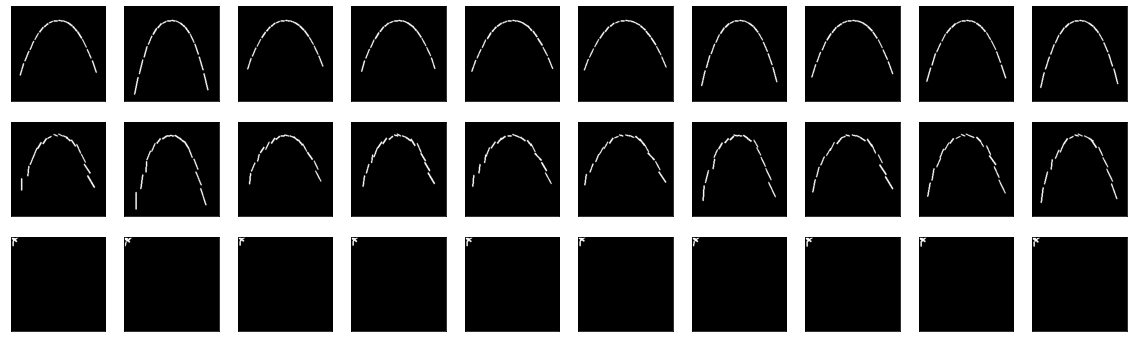

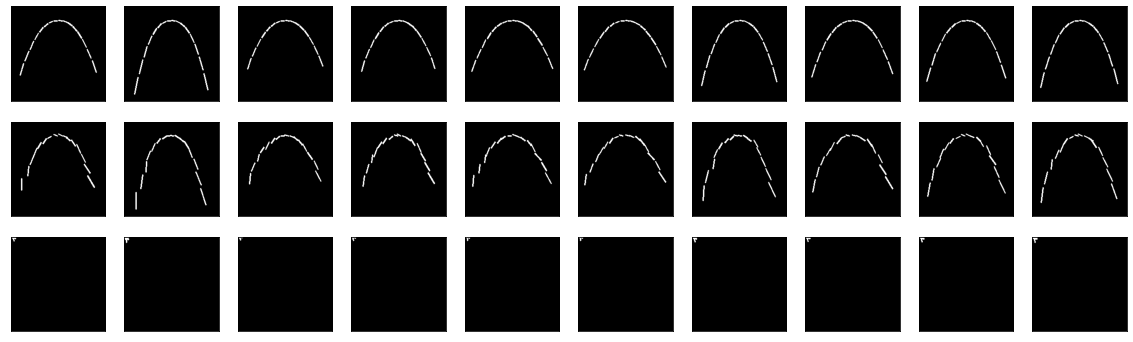

Epoch 10 loss -3308.69384765625


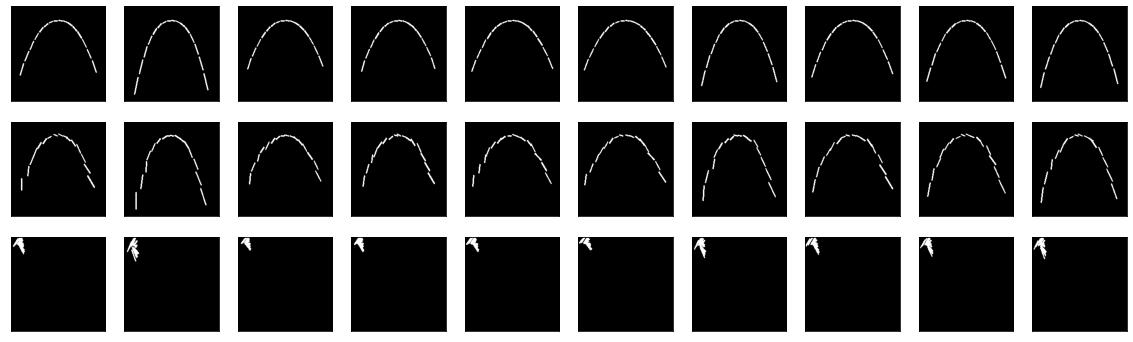

Epoch 20 loss -1409.099853515625
Epoch 30 loss -387.27301025390625


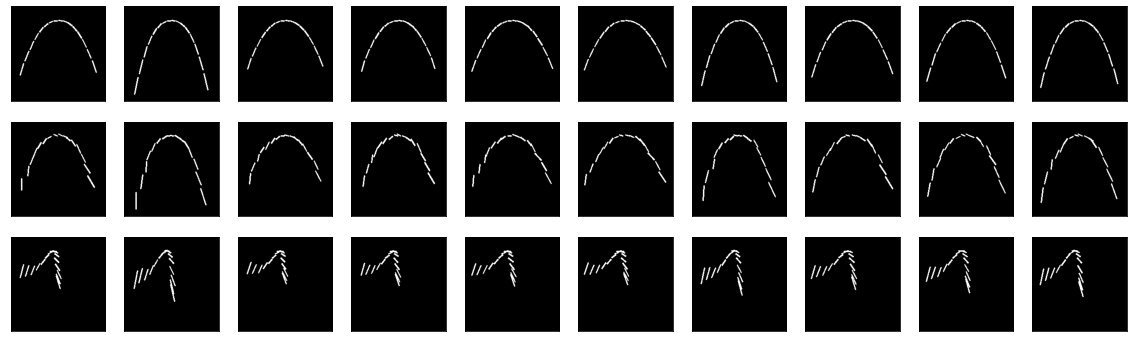

Epoch 40 loss -78.17201232910156
Epoch 50 loss -13.688838005065918
Epoch 60 loss -2.2897417545318604
Epoch 70 loss -0.4718860685825348
Epoch 80 loss -0.22557178139686584


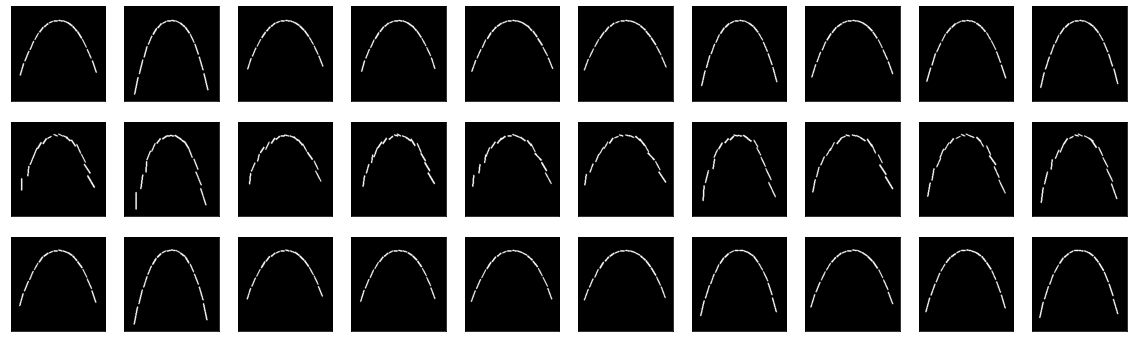

Epoch 90 loss -0.20267817378044128
Epoch 100 loss -0.25408926606178284
Epoch 110 loss -0.21637418866157532
Epoch 120 loss -0.20861545205116272
Epoch 130 loss -0.20417450368404388
Epoch 140 loss -0.20086538791656494
Epoch 150 loss -0.19788417220115662
Epoch 160 loss -0.19482168555259705
Epoch 170 loss -0.19212904572486877
Epoch 180 loss -0.1900874823331833
Epoch 190 loss -0.18824541568756104
Epoch 200 loss -0.1867401897907257
Epoch 210 loss -0.18570850789546967
Epoch 220 loss -0.18282485008239746
Epoch 230 loss -0.18007886409759521
Epoch 240 loss -0.17535027861595154
Epoch 250 loss -0.17270037531852722
Epoch 260 loss -0.17025808990001678
Epoch 270 loss -0.16802938282489777
Epoch 280 loss -0.16547545790672302
Epoch 290 loss -0.16269519925117493
Epoch 300 loss -0.15910427272319794
Epoch 310 loss -0.15535826981067657
Epoch 320 loss -0.15342281758785248
Epoch 330 loss -0.15252923965454102
Epoch 340 loss -0.1518915444612503
Epoch 350 loss -0.15171651542186737
Epoch 360 loss -0.15168003737926

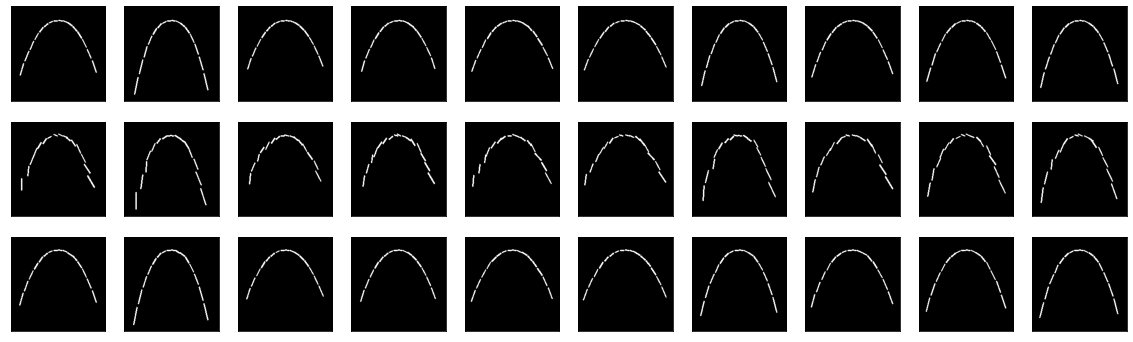

Epoch 1010 loss -0.13867789506912231
Epoch 1020 loss -0.13928411900997162
Epoch 1030 loss -0.14081282913684845
Epoch 1040 loss -0.14374469220638275
Epoch 1050 loss -0.13949081301689148
Epoch 1060 loss -0.1377480924129486
Epoch 1070 loss -0.1357739269733429
Epoch 1080 loss -0.13613934814929962
Epoch 1090 loss -0.13507720828056335
Epoch 1100 loss -0.14079244434833527
Epoch 1110 loss -0.13508516550064087
Epoch 1120 loss -0.13689282536506653
Epoch 1130 loss -0.1332491934299469
Epoch 1140 loss -0.13375157117843628
Epoch 1150 loss -0.14333055913448334
Epoch 1160 loss -0.14118829369544983
Epoch 1170 loss -0.13569988310337067
Epoch 1180 loss -0.13490061461925507
Epoch 1190 loss -0.13384614884853363
Epoch 1200 loss -0.13525281846523285
Epoch 1210 loss -0.1363987922668457
Epoch 1220 loss -0.13252954185009003
Epoch 1230 loss -0.14057226479053497
Epoch 1240 loss -0.13220104575157166
Epoch 1250 loss -0.1329822540283203
Epoch 1260 loss -0.13297709822654724
Epoch 1270 loss -0.13363008201122284
Epoch 

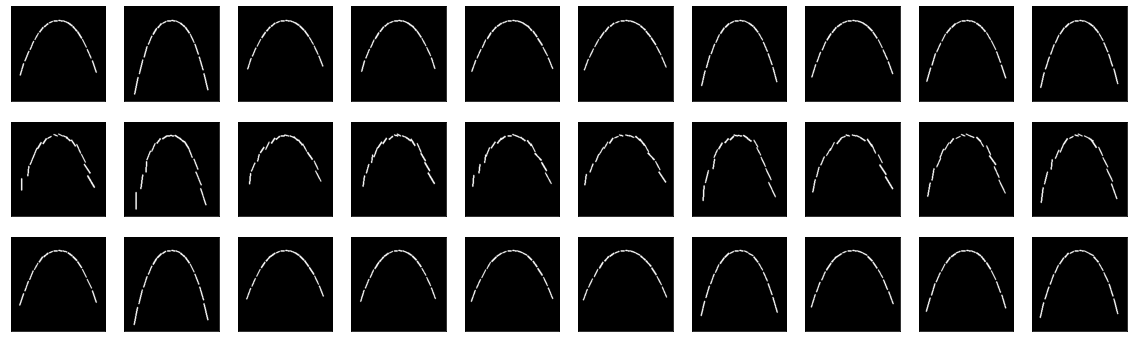

Epoch 2010 loss -0.13581012189388275
Epoch 2020 loss -0.13411083817481995
Epoch 2030 loss -0.13589896261692047
Epoch 2040 loss -0.13846097886562347
Epoch 2050 loss -0.13532771170139313
Epoch 2060 loss -0.13440155982971191
Epoch 2070 loss -0.13154679536819458
Epoch 2080 loss -0.13013851642608643
Epoch 2090 loss -0.12976567447185516
Epoch 2100 loss -0.129624143242836
Epoch 2110 loss -0.1294707953929901
Epoch 2120 loss -0.12992115318775177
Epoch 2130 loss -0.13334384560585022
Epoch 2140 loss -0.12978625297546387
Epoch 2150 loss -0.13076333701610565
Epoch 2160 loss -0.1365509331226349
Epoch 2170 loss -0.13411366939544678
Epoch 2180 loss -0.1335572451353073
Epoch 2190 loss -0.13349464535713196
Epoch 2200 loss -0.13280771672725677
Epoch 2210 loss -0.13032005727291107
Epoch 2220 loss -0.12985706329345703
Epoch 2230 loss -0.1311238706111908
Epoch 2240 loss -0.13090845942497253
Epoch 2250 loss -0.13130688667297363
Epoch 2260 loss -0.13401728868484497
Epoch 2270 loss -0.13177400827407837
Epoch 2

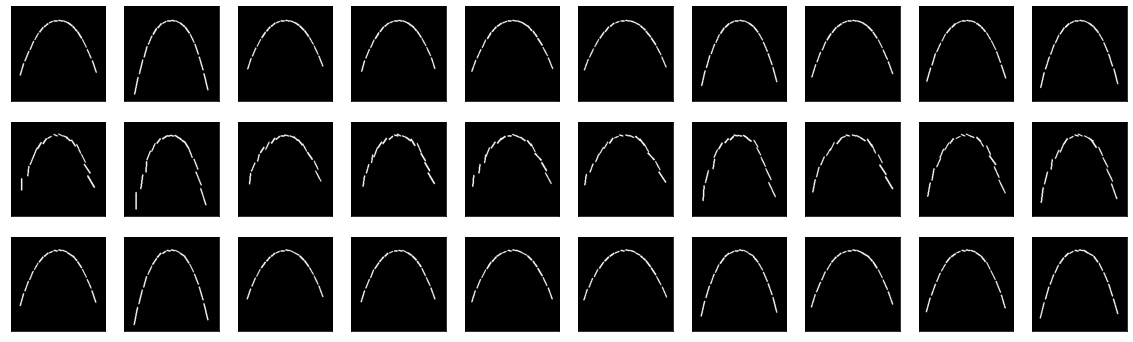

Epoch 3010 loss -0.1294647753238678
Epoch 3020 loss -0.1304958164691925
Epoch 3030 loss -0.12876394391059875
Epoch 3040 loss -0.12732791900634766
Epoch 3050 loss -0.12871232628822327
Epoch 3060 loss -0.1305498480796814
Epoch 3070 loss -0.12653829157352448
Epoch 3080 loss -0.1278008073568344
Epoch 3090 loss -0.12659239768981934
Epoch 3100 loss -0.1259734034538269
Epoch 3110 loss -0.1265266090631485
Epoch 3120 loss -0.13029971718788147
Epoch 3130 loss -0.13049602508544922
Epoch 3140 loss -0.12764641642570496
Epoch 3150 loss -0.13003024458885193
Epoch 3160 loss -0.12789446115493774
Epoch 3170 loss -0.1283796727657318
Epoch 3180 loss -0.12779857218265533
Epoch 3190 loss -0.1280711591243744
Epoch 3200 loss -0.12994864583015442
Epoch 3210 loss -0.1295802742242813
Epoch 3220 loss -0.12724390625953674
Epoch 3230 loss -0.1266108900308609
Epoch 3240 loss -0.12638086080551147
Epoch 3250 loss -0.12612642347812653
Epoch 3260 loss -0.1261296421289444
Epoch 3270 loss -0.12599965929985046
Epoch 3280 l

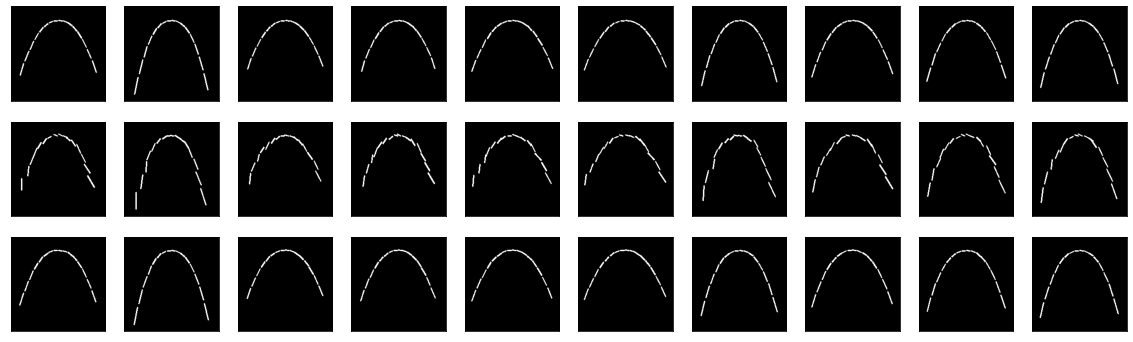

Epoch 4010 loss -0.12460587918758392
Epoch 4020 loss -0.1256786435842514
Epoch 4030 loss -0.1263582855463028
Epoch 4040 loss -0.12379365414381027
Epoch 4050 loss -0.12801416218280792
Epoch 4060 loss -0.1284875124692917
Epoch 4070 loss -0.12670977413654327
Epoch 4080 loss -0.1252172887325287
Epoch 4090 loss -0.13051475584506989
Epoch 4100 loss -0.13262690603733063
Epoch 4110 loss -0.12707549333572388
Epoch 4120 loss -0.12618106603622437
Epoch 4130 loss -0.1440349519252777
Epoch 4140 loss -0.1277705430984497
Epoch 4150 loss -0.12386564910411835
Epoch 4160 loss -0.12359948456287384
Epoch 4170 loss -0.12352662533521652
Epoch 4180 loss -0.12345986068248749
Epoch 4190 loss -0.12333269417285919
Epoch 4200 loss -0.12322533130645752
Epoch 4210 loss -0.12319260835647583
Epoch 4220 loss -0.12316024303436279
Epoch 4230 loss -0.12314797192811966
Epoch 4240 loss -0.12314540147781372
Epoch 4250 loss -0.12313057482242584
Epoch 4260 loss -0.12309558689594269
Epoch 4270 loss -0.12308630347251892
Epoch 4

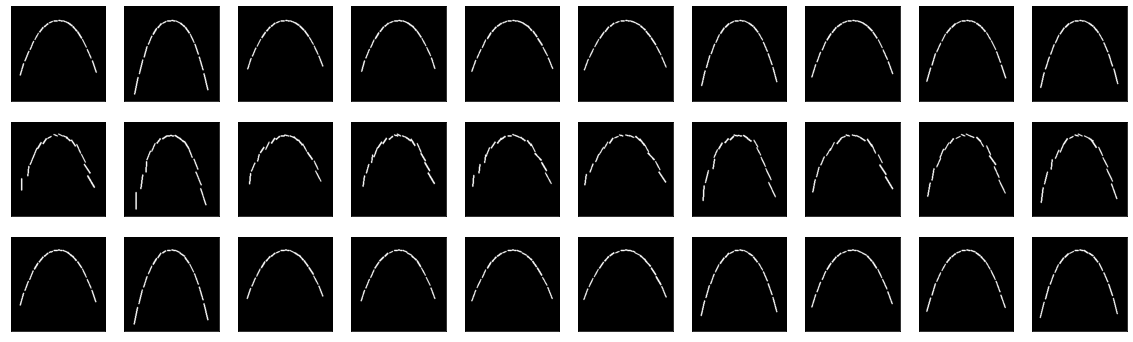

In [20]:
# вместо фита будем делать  model.train_on_batch читобы смотреть как учится и куда движемся
def train_on_batch(x, x_spoil, vec, vec_spoil, batch_size=batch_size, epochs=100):
    # подровняем массив картинок и обучающих векторов так, чтоб np.reshape не ругался - на несовпадение размерности
    # сделаем его длину кратной размеру батча
    # print (f"x_train.shape {x_train.shape}")            # (8000, 200, 200, 1)
    # print (f"x_train_vec.shape {x_train_vec.shape}")    # (8000, 16, 4)
    # print (f"x shape {x.shape}")                        # (8000, 200, 200, 1)
    # print (f"vec shape {vec.shape}")                    # (8000, 16, 4)
    # print (f"x_spoil shape {x_spoil.shape}")            # (8000, 200, 200, 1)
    # print (f"vec_spoil shape {vec_spoil.shape}")        # (8000, 16, 4)

    x =     x   [:len(x_train)//    batch_size*batch_size]
    vec =   vec [:len(x_train_vec)//batch_size*batch_size]
    x =     np.reshape(x,   (-1, batch_size, 200, 200, 1))  # x_test  = np.reshape(x_test,  (len(x_test),  200, 200, 1))
    vec =   np.reshape(vec, (-1, batch_size, 64))           # x_test  = np.reshape(x_test,  (len(x_test),  200, 200, 1))
    
    # и массив кореженных тоже
    x_spoil =   x_spoil     [:len(x_train_spoiled)      //batch_size*batch_size]
    vec_spoil = vec_spoil   [:len(x_train_vec_spoiled)  //batch_size*batch_size]
    x_spoil =   np.reshape(x_spoil,     (-1, batch_size, 200, 200, 1)) 
    vec_spoil = np.reshape(vec_spoil,   (-1, batch_size, 64)) 

    # print (f"\n\nx shape {x.shape}")                    # (31, 256, 200, 200, 1)
    # print (f"vec shape {vec.shape}")                    # (31, 256, 64)
    # print (f"x_spoil shape {x_spoil.shape}")            # (31, 256, 200, 200, 1)
    # print (f"vec_spoil shape {vec_spoil.shape}")        # (31, 256, 64)
    
    for epoch in range(1, epochs+1):
        # print(f"Epoch {epoch}")
        for i, _ in enumerate(vec):
            batch_x =           x[i]
            batch_x_spoil =     x_spoil[i]    
            batch_vec =         vec[i] 
            batch_vec_spoiled = vec_spoil[i]

            loss = denoiser_model.train_on_batch([batch_vec, batch_vec_spoiled], batch_vec)

        # эпоха отучилась, построим что вышло.
        n = 10
        vecs = batch_vec                    # это последний батч в каждой эпохе.
        # print (f"1! vecs shape{vecs.shape}") # shape - (256, 64)
        noised_vecs = batch_vec_spoiled     
        # а картинки не участвуют в учении, количество бачей у них при делении датасета на бачи
        # с векторами разное, поэтому найти соответствующую картинку проблематично. 
        # noised_imgs = noiser.predict(imgs, batch_size=batch_size)

        # задача в том, чтобы картинке сопоставить спойленую картинку ( это не сложно из сгенерированной 
        # выборки сделать), но потом предиктить для этой картинки вектора. и рисовать их на новой картинке 
        # средствами opencv 
        encoded_vecs = encoder.predict(noised_vecs[:n],  batch_size=n)
        decoded_vecs = decoder.predict(encoded_vecs[:n], batch_size=n)

        # формируем картинки из предсказанных векторов
        # print (f"vecs shape{vecs.shape} vecs[0] {vecs[0]}")
        vecs =              np.reshape(vecs,            (-1, 16, 4))
        noised_vecs =       np.reshape(noised_vecs,     (-1, 16, 4))
        predicted_vecs =    np.reshape(decoded_vecs,    (-1, 16, 4))
        
        # print (f"vecs shape{vecs.shape} vecs[0] {vecs[0]}")
        
        imgs_fr_vec =           np.array([img for img in map(inst_.draw_pic_fr_vec, vecs)])
        imgs_spoil_fr_vec =     np.array([img for img in map(inst_.draw_pic_fr_vec, noised_vecs)])
        imgs_fr_decoded_vec =   np.array([img for img in map(inst_.draw_pic_fr_vec, predicted_vecs)])

        # print (f"batch_x shape{     np.array(batch_x).shape}")      # (256, 200, 200, 1)
        # print (f"imgs_fr_vec shape{ np.array(imgs_fr_vec).shape}")  # (256, 200, 200)
        if epoch%10 ==0:
            print(f"Epoch {epoch} loss -{loss}")
        # рисуем картинки и сохраняем модели
        # if (epoch % 20 ==0) or (epoch in [1,2,3,5,10]):
        if (epoch % 1000 ==0) or (epoch in [1,2, 10, 30, 80]):
            # print(f'Epoch {epoch}')
            # plot_digits(batch_x[:n], batch_x_spoil[:n], imgs_fr_vec[:n], imgs_spoil_fr_vec[:n], imgs_fr_decoded_vec[:n])            
            plot_digits(imgs_fr_vec[:n], imgs_spoil_fr_vec[:n], imgs_fr_decoded_vec[:n])
            # plot_digits(batch_x[:n], batch_x_spoil[:n])
            # denoiser_model.save(f'models/denoiser_1_flt_{epoch}ep.h5')
            # decoder.save(f'models/c_decoder_1_flt_{epoch}ep.h5')
            # encoder.save(f'models/c_encoder_1_flt_{epoch}ep.h5')
        
# train_on_batch(x_train, batch_size=batch_size, epochs=100)
# train_on_batch(x_train, x_train_spoiled, batch_size=batch_size, epochs=100)
train_on_batch(x_train, x_train_spoiled, x_train_vec, x_train_vec_spoiled, batch_size=batch_size, epochs=5000)

In [21]:
# c_autoencoder.save(f'models/c_autoencoder.h5'

n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = с_encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = с_decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)
# plot_digits(imgs[:n], decoded_imgs)

encoded_imgs[:20]